# Tuto fonction fastmri

## Import 

In [1]:
import fastmri
from fastmri.data import transforms as T
import h5py
import numpy as np
from matplotlib import pyplot as plt

from utils_torch import virtual_coil_reconstruction, show_coils

import sys
sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src')

## Download data 

In [2]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
hf = h5py.File(file_path)
# print(hf)

## Manipulate data to understand and have the right format

In [3]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 16, 640, 320)


In [4]:
slice_kspace = volume_kspace[volume_kspace.shape[0]-1] # Choosing the lastest slice of this volume
# print(slice_kspace)

In [5]:
num_coils = slice_kspace.shape[0] # number of coils in the k-space

slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
print(slice_kspace2.shape)
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
print(slice_image.shape)
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
print(slice_image_abs.shape)
# print(slice_image_abs)

# for coil_index in range(num_coils):
#     show_coils(np.log(np.abs(slice_kspace) + 1e-9), [coil_index])
#     show_coils(slice_image_abs, [coil_index], cmap='gray')

torch.Size([16, 640, 320, 2])
torch.Size([16, 640, 320, 2])
torch.Size([16, 640, 320])


## Test for undersampling Mask 

### Original image

In [6]:
#   Transformation multicoil into singlecoil

new_image_singlecoil = virtual_coil_reconstruction(slice_image_abs) # image de base 

print(slice_image_abs.shape)
print(new_image_singlecoil.shape)

torch.Size([16, 640, 320])
torch.Size([640, 320])


/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon/functions_torch/utils_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(imgs, dtype=torch.complex64)
/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon/functions_torch/utils_torch.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phase_reference = torch.tensor(


### Fastmri

Choose the sampling mask you want between the following.

random : genere a sampling mask randomly  
equispaced : genere a sampling mask with qually-spaced k-space lines  
equispaced_fraction : similar to equispaced with more precision about acceleration rate  
magic : genere a sampling mask who exploit conjugate symmetry  
magic_fraction : similar to magic with more precision about acceleration rate  

In [7]:
from fastmri.data.subsample import create_mask_for_mask_type

mask_type_str = "random"
center_fractions = [0.08, 0.04]
accelerations = [4, 8]

mask_func = create_mask_for_mask_type(mask_type_str, center_fractions, accelerations)

masked_func represent here the binary data of the mask.   
0 mean informatiosn in the data are note conserve.   
1 mean you take the information.   
    
accelerated_data is the fusion between the original data and sampling data.   
This is the data we gonna use.

In [8]:
testLena = virtual_coil_reconstruction(slice_image_abs)
print(testLena.shape)

from mri_dlrecon.functions_tf.utils_tf import virtual_coil_reconstruction as VR
testLena2 = VR(slice_image_abs)
print(testLena2.shape)

masked_data , _ = mask_func(testLena.shape) 
# print(masked_data)

accelerated_data = slice_image_abs * masked_data
# print(accelerated_data)

torch.Size([640, 320])


2023-12-15 15:18:57.215191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 15:18:57.215236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 15:18:57.217060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 15:18:57.226477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 15:18:59.786925: W tensorflow/compiler/tf2

(16, 320) tgtgtt
(16, 320)


ValueError: Shape should have 3 or more dimensions

function who transform multicoil_data into singlecoil_data

In [ ]:
# new_image_singlecoil_Masked = virtual_coil_reconstruction(accelerated_data) # image with sampling mask
new_image_singlecoil_Masked = accelerated_data

### Fasmri Reproductible Benchmark

In [ ]:

# def gen_mask(kspace, accel_factor=8, seed=None):
#     # inspired by https://github.com/facebookresearch/fastMRI/blob/master/common/subsample.py
#     shape = kspace.shape
#     num_cols = shape[-1]
#     center_fraction = (32 // accel_factor) / 100
#     acceleration = accel_factor

#     # Create the mask
#     num_low_freqs = int(round(num_cols * center_fraction))
#     prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
#     mask = np.random.default_rng(seed).uniform(size=num_cols) < prob
#     pad = (num_cols - num_low_freqs + 1) // 2
#     mask[pad:pad + num_low_freqs] = True

#     # Reshape the mask
#     mask_shape = [1 for _ in shape]
#     mask_shape[-1] = num_cols
#     mask = mask.reshape(*mask_shape)
#     return mask

def gen_mask(kspace, accel_factor=8):
    shape = kspace.shape
    num_cols = shape[-1]

    center_fraction = (32 // accel_factor) / 100
    acceleration = accel_factor

    # Create the mask
    num_low_freqs = int(round(num_cols * center_fraction))
    prob = (num_cols / acceleration - num_low_freqs) / (num_cols - 3 * num_low_freqs)
    num_sampling = int(prob * num_cols)
    # selected_indexes = np.random.default_rng().randint(0, num_cols, size=(num_sampling, 2)).mean(axis=-1).astype('int')
    selected_indexes = np.random.default_rng().choice(num_cols, size=num_sampling, replace=False)
    mask = np.zeros((num_cols,)).astype('bool')
    mask[selected_indexes] = True
    pad = (num_cols - num_low_freqs + 1) // 2
    mask[pad:pad + num_low_freqs] = True

    # Reshape the mask
    mask_shape = [1 for _ in shape]
    mask_shape[-1] = num_cols
    mask = mask.reshape(*mask_shape)
    return mask

# import tensorflow as tf

# def gen_mask(kspace, accel_factor = 8, multicoil=False, fixed_masks=False):
#     shape = tf.shape(kspace)
#     num_cols = shape[-1] # initialement -1
#     center_fraction = (32 // accel_factor) / 100
#     num_low_freqs = tf.dtypes.cast(num_cols, 'float32') * center_fraction
#     num_low_freqs = tf.dtypes.cast((tf.round(num_low_freqs)), 'int32')
#     prob = (num_cols / accel_factor - tf.dtypes.cast(num_low_freqs, 'float64')) / tf.dtypes.cast((num_cols - num_low_freqs), 'float64')
#     if fixed_masks:
#         tf.random.set_seed(0)
#         seed = 0
#     else:
#         seed = None
#     mask = tf.random.uniform(shape=tf.expand_dims(num_cols, axis=0), dtype='float64', seed=seed) < prob
#     pad = (num_cols - num_low_freqs + 1) // 2
#     final_mask = tf.concat([
#         mask[:pad],
#         tf.ones([num_low_freqs], dtype=tf.bool),
#         mask[pad+num_low_freqs:],
#     ], axis=0)

#     # # Reshape the mask
#     mask_shape = tf.ones_like(shape)
#     if multicoil:
#         mask_shape = mask_shape[:3]
#     else:
#         mask_shape = mask_shape[:2]
#     final_mask_shape = tf.concat([
#         mask_shape,
#         tf.expand_dims(num_cols, axis=0),
#     ], axis=0)
#     final_mask_reshaped = tf.reshape(final_mask, final_mask_shape)
#     # we need the batch dimension for cases where we split the batch accross
#     # multiple GPUs
#     if multicoil:
#         final_mask_reshaped = tf.tile(final_mask_reshaped, [shape[0], 1, 1, 1])
#     else:
#         final_mask_reshaped = tf.tile(final_mask_reshaped, [shape[0], 1, 1])
#     fourier_mask = tf.cast(final_mask_reshaped, tf.uint8)
#     return fourier_mask
#     return final_mask_reshaped


In [ ]:
#  Representation binaire qui indique quel point sera conservé. 

masked_data1 = gen_mask(slice_image_abs)
# print(masked_data.shape)

# numpy_array = masked_data1.numpy()
# import torch

# torch_tensor = torch.tensor(numpy_array, dtype=torch.float32)
# print(torch_tensor.shape)
# print(torch_tensor)

#  Relié cette representation binaire avec notre data
accelerated_data1 = slice_image_abs * masked_data1
# print(accelerated_data)

In [ ]:
#   Transformation multicoil into singlecoil

new_image_singlecoil_Masked_Zac = virtual_coil_reconstruction(accelerated_data1) # image avec le subsample mask

## Result 

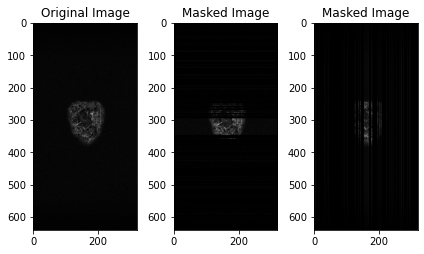

In [ ]:

plt.subplot(1, 3, 1)
plt.imshow(np.abs(new_image_singlecoil.numpy()), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(np.abs(new_image_singlecoil_Masked.numpy()), cmap='gray')
plt.title('Masked Image')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(new_image_singlecoil_Masked_Zac.numpy()), cmap='gray')
plt.title('Masked Image')

plt.tight_layout()
plt.show()
